<a href="https://colab.research.google.com/github/aradjabova/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/81_acc_and_autoencoder_code_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import os, os.path
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, SeparableConv2D, Activation, GaussianNoise, Input, UpSampling2D
from keras import backend as K
from imblearn.over_sampling import SMOTE
from keras.preprocessing import image
from keras import optimizers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import load_img




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Functions

In [0]:
def show_img(image_path):
  import numpy as np
  img = np.random.rand(150,150,3)
  img_path = image_path
  img = image.load_img(img_path, target_size=(150, 150))
  x = image.img_to_array(img)
  plt.figure(figsize=(8,8))
  plt.imshow(x/255.)
  plt.show()

In [0]:
def make_img_df(labels_list, directory, name_imgs='train', imgs='.jpg', labels=True, pix=False):

  data = []

  if pix is False:
    if labels:

      for num in range(len(labels_list)):
        path = directory / labels_list[num]
        name = str(labels_list[num])
        names = name_imgs +'_' + str(labels_list[num])
        img_path = path.glob('*'+ imgs)


      # Go through all the normal cases. The label for these cases will be 0
        for img in img_path:
          # pic = np.random.rand(150,150,3)
          # pic = image.load_img(img, target_size=(150, 150))
          # x = image.img_to_array(pic)
          data.append((img, name))
          
      df = pd.DataFrame(data, columns=['image_path', 'label'],index=None)
      df = df.sample(frac=1.).reset_index(drop=True)

      return df
    
    else:

      for num in range(len(labels_list)):
        path = directory 
        name = str(labels_list[num])
        names = name_imgs +'_' + str(labels_list[num])
        img_path = path.glob('*'+ imgs)


      # Go through all the normal cases. The label for these cases will be 0
        for img in img_path:
          data.append((img, 'None'))


          
      df = pd.DataFrame(data, columns=['image_path', 'label'],index=None)
      df = df.sample(frac=1.).reset_index(drop=True)


      return df

  if pix is True:
    if labels:

      for num in range(len(labels_list)):
        path = directory / labels_list[num]
        name = str(labels_list[num])
        names = name_imgs +'_' + str(labels_list[num])
        img_path = path.glob('*'+ imgs)


      # Go through all the normal cases. The label for these cases will be 0
        for img in img_path:
          pic = np.random.rand(150,150,3)
          pic = image.load_img(img, target_size=(150, 150))
          x = image.img_to_array(pic)
          data.append((img, name, x))
          
      df = pd.DataFrame(data, columns=['image_path', 'label', 'img_pix'],index=None)
      df = df.sample(frac=1.).reset_index(drop=True)

      return df
    
    else:

      for num in range(len(labels_list)):
        path = directory 
        name = str(labels_list[num])
        names = name_imgs +'_' + str(labels_list[num])
        img_path = path.glob('*'+ imgs)


      # Go through all the normal cases. The label for these cases will be 0
        for img in img_path:
          data.append((img, 'None'))


          
      df = pd.DataFrame(data, columns=['image_path', 'label'],index=None)
      df = df.sample(frac=1.).reset_index(drop=True)


      return df



In [0]:
def path_to_array(image_path):
  img = np.random.rand(150,150,3)
  img_path = image_path
  img = image.load_img(img_path, target_size=(150, 150))
  x = image.img_to_array(img)
  return x

# Load Images From kaggle

In [0]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Capstone/Kaggle"
# # /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [0]:
# %cd /content/drive/My Drive/Capstone/Kaggle

In [0]:
# pwd

In [0]:
# !kaggle datasets download -d puneet6060/intel-image-classification

In [0]:
# !ls

In [0]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [0]:
# !ls

# Creating Dataframe of images

In [0]:
path_train = Path('/content/drive/My Drive/Capstone/Kaggle/seg_train/seg_train')
path_test = Path('/content/drive/My Drive/Capstone/Kaggle/seg_test/seg_test')
path_pred = Path('/content/drive/My Drive/Capstone/Kaggle/seg_pred/seg_pred')

In [0]:
categories = ['buildings','forest','glacier','mountain','sea','street']

In [0]:
# train_df = make_img_df(categories, path_train, pix=True)
# test_df = make_img_df(categories, path_test, name_imgs='test')
# pred_df = make_img_df(categories, path_pred, name_imgs='pred', labels=False)

Buildings


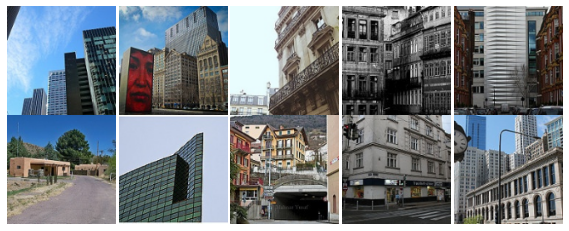

In [0]:
# import cv2
# print('Buildings')
# multipleImages = glob.glob('/content/drive/My Drive/Capstone/Kaggle/seg_train/seg_train/buildings/**')
# i_ = 0
# plt.rcParams['figure.figsize'] = (10.0, 10.0)
# plt.subplots_adjust(wspace=0, hspace=0)
# for l in multipleImages[:10]:
#     im = cv2.imread(l)
#     im = cv2.resize(im, (128, 128)) 
#     plt.subplot(5, 5, i_+1) #.set_title(l)
#     plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
#     i_ += 1

In [0]:
# cases_count = train_df['label'].value_counts()

# plt.figure(figsize=(13,8))
# sns.barplot(x=cases_count.index, y= cases_count.values)
# plt.title('Number of cases', fontsize=14)
# plt.xlabel('Case type', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.show()

The difference of images is not super wide!

- maybe will smote images?
- if not i dont think it will cause a difference but will test.

In [0]:
# show_img(train_df.image_path[2])

In [0]:
# show_img(train_df.image_path[3])

Awesome!


My images are 150, 150, 3

# CNN plain

In [0]:
# train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.3, horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [0]:
# train_generator = train_datagen.flow_from_directory(
#         # This is the target directory
#         path_train,
#          target_size=(256, 256),

#         # All images will be resized to 150x150
#         # Since we use binary_crossentropy loss, we need binary labels
#         class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(
#     path_test,
#     # target_size=(240, 240),
#     # batch_size=16,
#     class_mode='categorical')


In [0]:
# train_generator.labels

In [0]:
# input_shape = (256, 256, 3)

In [0]:
# model = Sequential()
# model.add(Conv2D(16,(4,4),activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D((3, 3)))
# model.add(Conv2D(8, (4, 4), activation='relu'))
# model.add(MaxPooling2D((3, 3)))
# model.add(Conv2D(8, (4, 4), activation='relu'))
# model.add(MaxPooling2D((3, 3)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(6, activation='softmax'))

# # 128conv2d
# # dense=128

In [0]:
# model.summary()

In [0]:
# checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
#     save_best_only=True, mode='auto', period=1)
# # checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# model.compile(optimizer='adam', 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])



In [0]:
# train= model.fit_generator(train_generator,
#                            validation_data=test_generator,
#                           #  steps_per_epoch=100,
#                            callbacks=[checkpoint],
#                            epochs=10) 


In [0]:
# model.evaluate_generator(test_generator)

In [0]:
# preds = model.predict_generator(test_generator)

In [0]:
# pred = np.argmax(preds, axis=1)

In [0]:
# accuracy=train.history['accuracy']
# val_acc=train.history['val_accuracy']
# loss=train.history['loss']
# val_loss=train.history['val_loss']
# epochs=list(range(10))


In [0]:
# import matplotlib.pyplot as plt
# plt.plot(epochs,accuracy)
# plt.title('Training Accuracy')
# plt.xlabel('EPOCHS')
# plt.ylabel('ACCURACY')
# plt.plot(epochs,val_acc)
# plt.legend(['TRAINING ACC','VAL ACC'])
# plt.show()

In [0]:
# plt.plot(epochs,loss)
# plt.xlabel('EPOCHS')
# plt.ylabel('LOSS')
# plt.plot(epochs,val_loss)
# plt.legend(['TRAINING LOSS','VAL LOSS']) 
# plt.title('Training Loss')
# plt.show()

In [0]:
# print(classification_report(test_generator.labels, pred))

In [0]:
# cm = confusion_matrix(test_generator.labels, pred)
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, cmap="Blues", annot=True, fmt='.3g', cbar=False)
# plt.title('Confusion Matrix')
# plt.show()

In [0]:
# recall_score(test_generator.labels, pred, average='micro')

# Auto encoded CNN


In [0]:
img_width, img_height = 256, 256
batch_size = 100

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    # horizontal_flip = True,
    vertical_flip = True,
    # rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.2
)
test_datagen = ImageDataGenerator(rescale = 1. / 255, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    # horizontal_flip = True,
    vertical_flip = True,
    # rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.2)

In [0]:
train_generator1 = train_datagen.flow_from_directory(
        # This is the target directory
        path_train,
        target_size=(256, 256),
        batch_size = batch_size,
        shuffle = True,

        # All images will be resized to 150x150
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='input')

test_generator1 = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size = batch_size,
    shuffle = True,
    class_mode='input')


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
input_img = Input(shape=(256,256,3))

In [0]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse',
                    metrics=['accuracy','mse'])


In [0]:
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 32)      0   

In [0]:
auto = autoencoder.fit_generator(
    train_generator1,
    epochs=5,
    validation_data=test_generator1
)

Epoch 1/5
 15/141 [==>...........................] - ETA: 17:29 - loss: 0.0725 - accuracy: 0.3903 - mse: 0.0725

KeyboardInterrupt: ignored

In [0]:
autoencoder.fit(x_train, x_train, 
                epochs=10,
                # # batch_size=1000,
                # steps_per_epoch=100,
                validation_data=(x_test, x_test))
                # validation_steps=100
                # )

In [0]:
autoencoder.evaluate_generator(test_generator1)

[0.002506619319319725, 0.8418180346488953, 0.0024517651181668043]

In [0]:
test_generator1.

array([1901, 1211, 1251, ..., 2463,  126, 2185])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


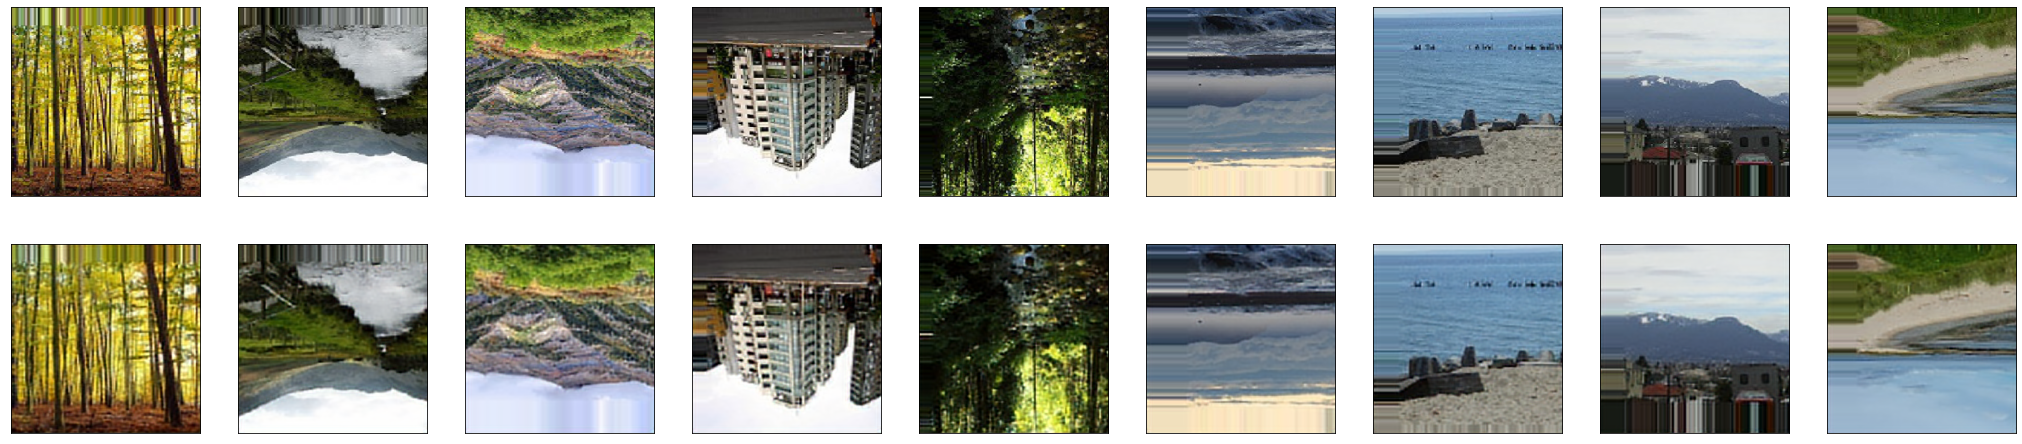

In [0]:
x_test, y_test = test_generator1.next()
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(40, 8))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



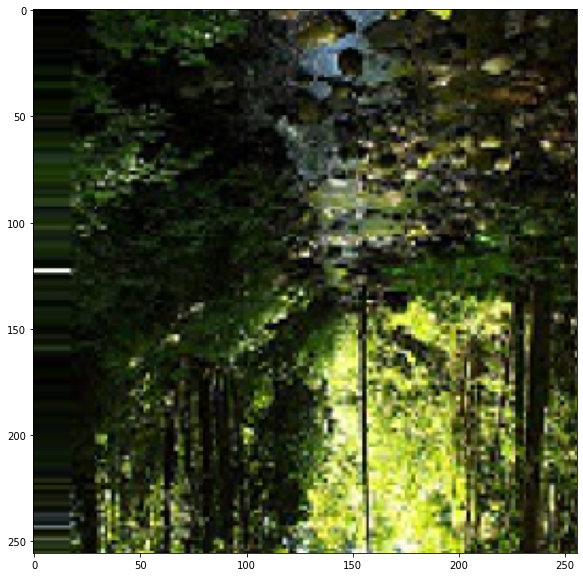

In [0]:
plt.imshow(x_test[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


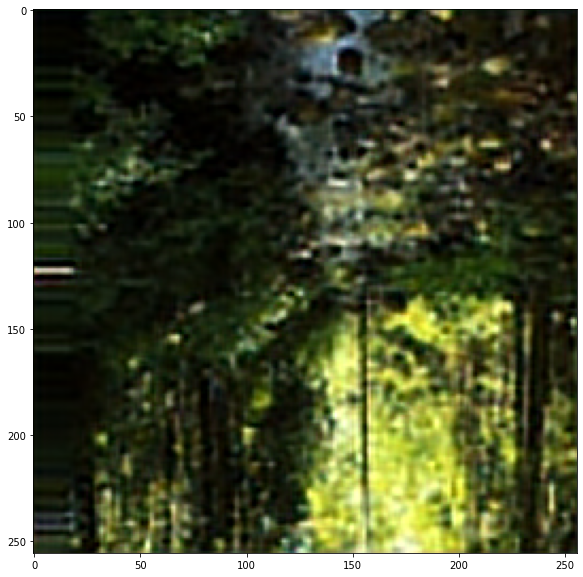

In [0]:
plt.imshow(decoded_imgs[5])

In [0]:
x_train_img_aug = autoencoder.predict_generator(train_generator1)


In [0]:
y_train_label = autoencoder.labels

In [0]:
# accuracy=auto.history['accuracy']
# val_acc=auto.history['val_accuracy']
# loss=auto.history['loss']
# val_loss=auto.history['val_loss']
# epochs=list(range(5))


In [0]:
# import matplotlib.pyplot as plt
# plt.plot(epochs,accuracy)
# plt.title('Training Accuracy')
# plt.xlabel('EPOCHS')
# plt.ylabel('ACCURACY')
# plt.plot(epochs,val_acc)
# plt.legend(['TRAINING ACC','VAL ACC'])
# plt.show()

In [0]:
# plt.plot(epochs,loss)
# plt.xlabel('EPOCHS')
# plt.ylabel('LOSS')
# plt.plot(epochs,val_loss)
# plt.legend(['TRAINING LOSS','VAL LOSS']) 
# plt.title('Training Loss')
# plt.show()

# Smoting to add more

# Creating a Test Dataframe

[]